### （1）将所有分类变量做哑编码；
###  （2）利用totally random treess embedding 方法对原始特征进行特征组合，生成新特征；
###  （3）剔除方差为零的变量；
###  （4）删除所有calc组内变量
### （5）将所有特征合并，训练lgb模型

In [1]:
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import RandomTreesEmbedding
import xgboost as xgb
from sklearn import metrics
import lightgbm as lgb
from copy import deepcopy
from sklearn.externals import joblib
from sklearn.preprocessing import OneHotEncoder
import graphviz
import win32com.client  
import winsound  
%matplotlib inline
plt.rcParams['figure.figsize']=12,4

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
data_path=r'D:\study\Competition\porto-sequro-safe-driver-prediction\data'
train_df=pd.read_csv(data_path+'\\train.csv',na_values=-1)
test_df=pd.read_csv(data_path+'\\test.csv',na_values=-1)

In [3]:
#所有变量
raw_features=[x for x in train_df.columns if x not in ['id','target']]
#所有二元变量
bin_features=[feat for feat in train_df.columns if 'bin' in feat]
#所有的分类变量
cat_features=[feat for feat in train_df.columns if 'cat' in feat]
#所有calc变量
calc_features=[feat for feat in train_df.columns if 'calc' in feat]

### 删除所有calc组内变量

In [7]:
train_df.drop(calc_features,axis=1,inplace=True)
test_df.drop(calc_features,axis=1,inplace=True)

In [14]:
raw_features=[x for x in train_df.columns if x not in ['id','target']]

In [8]:
train_df.head(3)

,id,target,ps_ind_01,ps_ind_02_cat,ps_ind_03,ps_ind_04_cat,ps_ind_05_cat,ps_ind_06_bin,ps_ind_07_bin,ps_ind_08_bin,...,ps_car_07_cat,ps_car_08_cat,ps_car_09_cat,ps_car_10_cat,ps_car_11_cat,ps_car_11,ps_car_12,ps_car_13,ps_car_14,ps_car_15
0,7,0,2,2.0,5,1.0,0.0,0,1,0,...,1.0,0,0.0,1,12,2.0,0.400000,0.883679,0.370810,3.605551
1,9,0,1,1.0,7,0.0,0.0,0,0,1,...,1.0,1,2.0,1,19,3.0,0.316228,0.618817,0.388716,2.449490
2,13,0,5,4.0,9,1.0,0.0,0,0,1,...,1.0,1,2.0,1,60,1.0,0.316228,0.641586,0.347275,3.316625


### One_Hot_Encoding

In [9]:
def get_dummy_feat(train_df,test_df,cat_features):
    oht_feat=pd.get_dummies(train_df[cat_features].append(test_df[cat_features]),columns=cat_features,dummy_na=True)
    train_df=train_df.join(oht_feat.iloc[0:train_df.shape[0]])
    test_df=test_df.join(oht_feat.iloc[train_df.shape[0]:])
    return train_df,test_df

In [10]:
train_df,test_df=get_dummy_feat(train_df,test_df,cat_features)

### Combined Feature(totally random trees)

In [11]:
rte=RandomTreesEmbedding(n_estimators=30,max_depth=4,max_leaf_nodes=10,sparse_output=False,n_jobs=-1,random_state=9)

In [12]:
def combine_feats(train_df,test_df,combine_raw_feats,combiner,na_fill_values=-1):
    combiner.fit(train_df[raw_features].fillna(na_fill_values))
    train_combine=combiner.transform(train_df[combine_raw_feats].fillna(na_fill_values))
    test_combine=combiner.transform(test_df[combine_raw_feats].fillna(na_fill_values))
    feat_names=['comb_'+str(i) for i in range(1,train_combine.shape[1]+1)]
    train_combine=pd.DataFrame(train_combine,columns=feat_names,index=train_df.index)
    test_combine=pd.DataFrame(test_combine,columns=feat_names,index=test_df.index)
    train_df=train_df.join(train_combine)
    test_df=test_df.join(test_combine)
    return train_df,test_df

In [15]:
train_df,test_df=combine_feats(train_df,test_df,raw_features,rte,na_fill_values=-1)

### 方差为0（或取值唯一）的变量

In [16]:
useless_feats=list(train_df.columns[train_df.var()==0])

In [17]:
use_features=[x for x in train_df.columns if x not in ['id','target']+cat_features+useless_feats]

In [18]:
X=train_df[use_features]
y=train_df['target']

X_predict=test_df[use_features]

In [19]:
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.20,stratify=y,random_state=9)

# 1 Base line

In [21]:
def gini(actual, pred, cmpcol = 0, sortcol = 1):
    assert( len(actual) == len(pred) )
    all = np.asarray(np.c_[ actual, pred, np.arange(len(actual)) ], dtype=np.float)
    all = all[ np.lexsort((all[:,2], -1*all[:,1])) ]
    totalLosses = all[:,0].sum()
    giniSum = all[:,0].cumsum().sum() / totalLosses
 
    giniSum -= (len(actual) + 1) / 2.
    return giniSum / len(actual)

def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum() 

def gini_normalized(preds,dtrain):
    y=dtrain.get_label()
    preds=softmax(preds)
    return 'NormGini',gini(y, preds) / gini(y, y),True

def gini_normalized_ordinary(y,preds):
    return gini(y, preds) / gini(y, y)

def modelfit(alg,X,y,X_test,y_test,cat_features,cvparams,folds=None,useTrainCV=True,cv_folds=5,early_stopping_rounds=30):
    feature_names=list(X.columns)
    if useTrainCV==True:
        dtrain=lgb.Dataset(X, label=y, max_bin=255, reference=None, 
                           weight=None, group=None, silent=False, feature_name=feature_names,
                            categorical_feature=cat_features,params=None, free_raw_data=True)
        cvresult=lgb.cv(cvparams,dtrain,num_boost_round=50000,folds=folds,nfold=cv_folds,stratified=True,
                        metrics='auc',feature_name=feature_names,categorical_feature=cat_features,early_stopping_rounds=early_stopping_rounds,
                        verbose_eval=20,show_stdv =True,seed=9)
        #,feval=gini_normalized
        alg.set_params(n_estimators=len(cvresult['auc-mean']))
        print('Best Iteration:',len(cvresult['auc-mean']))
        
    alg.fit(X,y,eval_metric='auc',feature_name=feature_names,categorical_feature=cat_features)
    
    #Predict training set:
    dtrain_predictions=alg.predict(X)
    dtrain_predprob=alg.predict_proba(X)[:,1]
    
    #pPredict test set:
    dtest_predictions=alg.predict(X_test)
    dtest_predprob=alg.predict_proba(X_test)[:,1]
    
    #Print Mode report:
    print('Model report on trian:')
    #print('Train Accuracy:{0:.4f}'.format(metrics.accuracy_score(y,dtrain_predictions)))
    print('Train AUC:{0:.4f}'.format(metrics.roc_auc_score(y,dtrain_predprob)))
    #print('Train Normalized GINI：{0:.6f}'.format(gini_normalized_ordinary(y,dtrain_predprob)))
    print('Model report on test:')
    #print('Test Accuracy:{0:.4f}'.format(metrics.accuracy_score(y_test,dtest_predictions)))
    print('Test AUC:{0:.4f}'.format(metrics.roc_auc_score(y_test,dtest_predprob)))
    #print('Test Normalized GINI：{0：.6f}'.format(gini_normalized_ordinary(y,dtest_predprob)))
    print('Test classifiction report:')
    print(metrics.classification_report(y_test,dtest_predictions))
    print('Test confusion matrix:')
    plt.figure()
    with sns.axes_style(style='dark'):
        plot_confusion_matrix(metrics.confusion_matrix(y_test,dtest_predictions),classes=['0','1'],
                             title='Confusion Matrix')
    
    feat_imp=pd.Series(alg.feature_importances_,index=X.columns).sort_values(ascending=True)
    #plt.figure()
    #feat_imp.plot(kind='barh',title='Feature Importances',color='green')
    #plt.ylabel('Feature Importance Score')
    lgb.plot_importance(alg,importance_type='split')
    return feat_imp

def turnParams(model,X,y,cat_features,searchParam,modelparams,scoring='roc_auc',cv=5):
    gsc=GridSearchCV(estimator=model.__class__(**modelparams),param_grid=searchParam,scoring=scoring,
                    iid=False,cv=cv)
    gsc.fit(X,y,eval_metric='auc',categorical_feature=cat_features)
    param_name=list(searchParam.keys())[0]
    columns=[p[param_name] for p in gsc.cv_results_['params']]
    cv_scores=pd.DataFrame([gsc.cv_results_['mean_test_score'],
                            gsc.cv_results_['mean_train_score'],
                            gsc.cv_results_['std_test_score'],
                            gsc.cv_results_['std_train_score']],
                            index=['mean_test_score','mean_train_score','std_test_score','std_train_score'],
                            columns=columns).T
    #cv_scores.index.name=param_name
    for param in gsc.best_params_.keys():
        modelparams[param]=gsc.best_params_[param]
    print('Best params:')
    for param in gsc.best_params_.keys():
        print(param,':',gsc.best_params_[param])
    print('Best score:',gsc.best_score_)
    print(cv_scores)
    speak = win32com.client.Dispatch('SAPI.SPVOICE')  
    winsound.Beep(20170, 800)  
    speak.Speak('程序运行完毕!')
    
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [22]:
params={'boosting_type':'gbdt',
        'num_leaves':50,
        'max_depth':20,
        'learning_rate':0.2,
        'n_estimators':100,
        'max_bin':255,
        'objective':'binary',
        'min_split_gain':0,
        'min_child_weight':0,
        'min_child_samples':1,
        'subsample':1.0,
        'subsample_freq':1,
        'colsample_bytree':1.0,
        'reg_alpha':0,
        'reg_lambda':0,
        'random_state':9,
        'n_jobs':4,
        'is_unbalance':True,
       }

cvparams={'boosting_type':'gbdt',
        'num_leaves':20,
        'max_depth':6,
        'learning_rate':0.2,
        'max_bin':255,
        'objective':'binary',
        'min_gain_to_split':0,
        'min_sum_hessian_in_leaf':0,
        'min_data_in_leaf':1,
        'bagging_fraction':1.0,
        'bagging_freq':1,
        'feature_fraction':1.0,
        'lambda_l1':0,
        'lambda_l2':0,
        'num_threads':4,
        'is_unbalance':True,
       }
#在sklaearn接口中，参数名称发生了变化，需要进行映射
tran_table={ 'min_split_gain':'min_gain_to_split',
             'min_child_weight':'min_sum_hessian_in_leaf',
             'min_child_samples':'min_data_in_leaf',
             'subsample':'bagging_fraction',
             'subsample_freq':'bagging_freq',
             'colsample_bytree':'feature_fraction',
             'reg_alpha':'lambda_l1',
             'reg_lambda':'lambda_l2',
             'n_jobs':'num_threads',
            
             'boosting_type':'boosting_type',
             'num_leaves':'num_leaves',
             'max_depth':'max_depth',
             'learning_rate':'learning_rate',
             'max_bin':'max_bin',
             'objective':'objective',
             'is_unbalance':'is_unbalance'}
def get_lgb_params(sklearn_params,cvparams,tran_table):
    for sklearn_param,lgb_param in tran_table.items():
        cvparams[lgb_param]=sklearn_params[sklearn_param]

In [23]:
lgbc=lgb.LGBMClassifier(**params)

[20]	cv_agg's auc: 0.63363 + 0.00250298
[40]	cv_agg's auc: 0.629631 + 0.00355401
[60]	cv_agg's auc: 0.624103 + 0.00310276
Best Iteration: 19
Model report on trian:
Train AUC:0.6842
Model report on test:
Test AUC:0.6364
Test classifiction report:
             precision    recall  f1-score   support

          0       0.97      0.63      0.77    114704
          1       0.05      0.56      0.10      4339

avg / total       0.94      0.63      0.74    119043

Test confusion matrix:
Confusion matrix, without normalization
[[72817 41887]
 [ 1928  2411]]


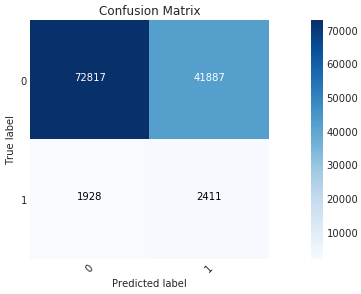

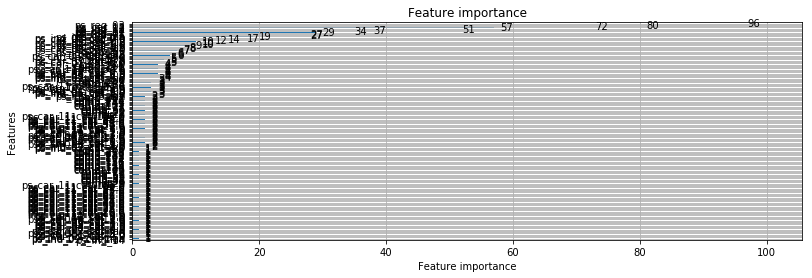

In [24]:
get_lgb_params(lgbc.get_params(),cvparams,tran_table)

feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

In [25]:
params['n_estimators']=19

# 2 Tune params

In [26]:
#不重要的警告信息不予显示
import warnings
warnings.filterwarnings("ignore")

## 2.1 subsample

In [27]:
searchParam={'subsample':[0.95,0.96,0.97,0.98,0.99,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
subsample : 0.98
Best score: 0.633653622918
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.95         0.632744          0.692820        0.005506         0.001690
0.96         0.632079          0.693153        0.005787         0.001343
0.97         0.632424          0.694031        0.004091         0.000997
0.98         0.633654          0.693887        0.003830         0.001200
0.99         0.633586          0.694066        0.004236         0.001400
1.00         0.633147          0.693868        0.005768         0.001065


## 2.3 colsample_bytree

In [28]:
searchParam={'colsample_bytree':[0.1,0.3,0.5,0.7,0.9,1.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 0.7
Best score: 0.63387008094
     mean_test_score  mean_train_score  std_test_score  std_train_score
0.1         0.623384          0.664490        0.004325         0.001421
0.3         0.632031          0.681543        0.004022         0.000796
0.5         0.633222          0.687453        0.004493         0.001092
0.7         0.633870          0.691230        0.005404         0.001363
0.9         0.633808          0.692770        0.005646         0.001421
1.0         0.633654          0.693887        0.003830         0.001200


In [29]:
searchParam={'colsample_bytree':[0.55,0.6,0.65,0.7,0.75,0.8,0.85]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 0.65
Best score: 0.634567151196
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.55         0.633145          0.688393        0.004114         0.001834
0.60         0.633477          0.690051        0.004426         0.002172
0.65         0.634567          0.690135        0.005515         0.001565
0.70         0.633870          0.691230        0.005404         0.001363
0.75         0.632771          0.691541        0.005605         0.001188
0.80         0.633416          0.691581        0.004340         0.000885
0.85         0.633660          0.692376        0.004846         0.001068


In [30]:
searchParam={'colsample_bytree':[0.63,0.64,0.65,0.66,0.67]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
colsample_bytree : 0.65
Best score: 0.634567151196
      mean_test_score  mean_train_score  std_test_score  std_train_score
0.63         0.633945          0.689960        0.005088         0.001460
0.64         0.634220          0.689833        0.005127         0.001539
0.65         0.634567          0.690135        0.005515         0.001565
0.66         0.633768          0.690089        0.005115         0.001215
0.67         0.632320          0.689848        0.003360         0.001290


## 2.4 reg_alpha

In [31]:
searchParam={'reg_alpha':[5,10,15,20,25,30,35,40]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 40
Best score: 0.637191342922
    mean_test_score  mean_train_score  std_test_score  std_train_score
5          0.634618          0.688044        0.004875         0.001058
10         0.636871          0.686870        0.005858         0.001548
15         0.635767          0.685599        0.004836         0.001656
20         0.635575          0.684653        0.006002         0.001339
25         0.636613          0.684284        0.005995         0.001189
30         0.637060          0.683556        0.005409         0.001328
35         0.636862          0.682686        0.005796         0.001136
40         0.637191          0.681891        0.005198         0.001099


In [32]:
searchParam={'reg_alpha':[39,40,41,45,50]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 39
Best score: 0.637333348458
    mean_test_score  mean_train_score  std_test_score  std_train_score
39         0.637333          0.681667        0.005649         0.001325
40         0.637191          0.681891        0.005198         0.001099
41         0.637164          0.681629        0.005562         0.001101
45         0.636687          0.681094        0.005177         0.000897
50         0.636444          0.680632        0.005685         0.001258


In [33]:
searchParam={'reg_alpha':[36,37,38,39,39.5]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 39
Best score: 0.637333348458
      mean_test_score  mean_train_score  std_test_score  std_train_score
36.0         0.636718          0.682618        0.005063         0.001566
37.0         0.636804          0.682140        0.005291         0.001454
38.0         0.637295          0.682083        0.006046         0.001267
39.0         0.637333          0.681667        0.005649         0.001325
39.5         0.637275          0.681870        0.005387         0.001256


In [34]:
searchParam={'reg_alpha':[38.9,39,39.1]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 39.1
Best score: 0.637481062496
      mean_test_score  mean_train_score  std_test_score  std_train_score
38.9         0.636946          0.681802        0.005649         0.001056
39.0         0.637333          0.681667        0.005649         0.001325
39.1         0.637481          0.681463        0.005460         0.001204


In [35]:
searchParam={'reg_alpha':[39.1,39.15,39.2,39.3,39.4]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_alpha : 39.15
Best score: 0.637481652118
       mean_test_score  mean_train_score  std_test_score  std_train_score
39.10         0.637481          0.681463        0.005460         0.001204
39.15         0.637482          0.681459        0.005460         0.001204
39.20         0.637123          0.681568        0.005635         0.001168
39.30         0.637124          0.681560        0.005635         0.001169
39.40         0.636896          0.681565        0.005609         0.001188


## 2.5 reg_lambda

In [36]:
searchParam={'reg_lambda':[1.5,2,2.5,3,3.5,4,4.5]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 2.5
Best score: 0.637567505067
     mean_test_score  mean_train_score  std_test_score  std_train_score
1.5         0.636290          0.681767        0.004660         0.000994
2.0         0.636191          0.681822        0.004654         0.000949
2.5         0.637568          0.681603        0.005045         0.001111
3.0         0.637180          0.681639        0.005405         0.001085
3.5         0.637289          0.681578        0.005076         0.001056
4.0         0.637552          0.681508        0.005527         0.001072
4.5         0.637146          0.681506        0.005832         0.001163


In [37]:
searchParam={'reg_lambda':[2.3,2.4,2.5,2.6,2.7]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
reg_lambda : 2.5
Best score: 0.637567505067
     mean_test_score  mean_train_score  std_test_score  std_train_score
2.3         0.636877          0.681772        0.005463         0.001187
2.4         0.636856          0.681769        0.005479         0.001187
2.5         0.637568          0.681603        0.005045         0.001111
2.6         0.637323          0.681674        0.005384         0.001085
2.7         0.637323          0.681670        0.005384         0.001085


## 2.6 min_child_samples

In [38]:
searchParam={'min_child_samples':[1,2,3,4,5,6,7]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_samples : 4
Best score: 0.637567581046
   mean_test_score  mean_train_score  std_test_score  std_train_score
1         0.637568          0.681603        0.005045         0.001111
2         0.637568          0.681603        0.005045         0.001111
3         0.637568          0.681603        0.005045         0.001111
4         0.637568          0.681603        0.005045         0.001111
5         0.637568          0.681603        0.005045         0.001111
6         0.637568          0.681603        0.005045         0.001111
7         0.637568          0.681603        0.005045         0.001111


## 2.7 min_child_weight

In [39]:
searchParam={'min_child_weight':[0,1e-5,1e-3,0.1,0.5,1.0,3.0,5.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_weight : 3.0
Best score: 0.637629007182
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         0.637568          0.681603        0.005045         0.001111
0.00001         0.637568          0.681603        0.005045         0.001111
0.00100         0.637568          0.681603        0.005045         0.001111
0.10000         0.637568          0.681603        0.005045         0.001111
0.50000         0.637568          0.681603        0.005045         0.001111
1.00000         0.637568          0.681603        0.005045         0.001111
3.00000         0.637629          0.681587        0.004988         0.001109
5.00000         0.637629          0.681587        0.004988         0.001109


In [40]:
searchParam={'min_child_weight':[2.0,2.9,3.0,3.1,3.5,4.0]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_child_weight : 2.9
Best score: 0.637629007182
     mean_test_score  mean_train_score  std_test_score  std_train_score
2.0         0.637568          0.681603        0.005045         0.001111
2.9         0.637629          0.681587        0.004988         0.001109
3.0         0.637629          0.681587        0.004988         0.001109
3.1         0.637629          0.681587        0.004988         0.001109
3.5         0.637629          0.681587        0.004988         0.001109
4.0         0.637629          0.681587        0.004988         0.001109


## 2.9 min_split_gain

In [42]:
searchParam={'min_split_gain':[0,1e-5,1e-4,1e-3,1e-2]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
min_split_gain : 0
Best score: 0.637629007182
         mean_test_score  mean_train_score  std_test_score  std_train_score
0.00000         0.637629          0.681587        0.004988         0.001109
0.00001         0.637629          0.681587        0.004988         0.001109
0.00010         0.637571          0.681529        0.005054         0.001033
0.00100         0.637571          0.681529        0.005054         0.001033
0.01000         0.637569          0.681522        0.005052         0.001029


## 2.10 num_leaves

In [44]:
searchParam={'num_leaves':[45,50,55,60,70]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 50
Best score: 0.637629007182
    mean_test_score  mean_train_score  std_test_score  std_train_score
45         0.636355          0.677975        0.005132         0.001488
50         0.637629          0.681587        0.004988         0.001109
55         0.636528          0.685611        0.005112         0.001504
60         0.637053          0.689567        0.005218         0.001398
70         0.635619          0.695831        0.005509         0.001285


In [45]:
searchParam={'num_leaves':[46,48,49,50,51,52,53]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
num_leaves : 50
Best score: 0.637629007182
    mean_test_score  mean_train_score  std_test_score  std_train_score
46         0.636712          0.678913        0.006490         0.001410
48         0.636926          0.680268        0.005579         0.000436
49         0.636711          0.680972        0.004927         0.000992
50         0.637629          0.681587        0.004988         0.001109
51         0.636010          0.682667        0.005416         0.001174
52         0.636921          0.683520        0.004810         0.001343
53         0.636979          0.684133        0.004954         0.001112


## 2.10 max_depth

In [46]:
searchParam={'max_depth':[8,9,10,11,12]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 10
Best score: 0.637475138852
    mean_test_score  mean_train_score  std_test_score  std_train_score
8          0.636463          0.679495        0.005743         0.001031
9          0.637003          0.680608        0.005344         0.001308
10         0.637475          0.680886        0.004867         0.001312
11         0.637104          0.681369        0.005650         0.001168
12         0.637035          0.681300        0.005077         0.001206


In [47]:
searchParam={'max_depth':[10,13,15,17,19,20,21,23]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 17
Best score: 0.637629007182
    mean_test_score  mean_train_score  std_test_score  std_train_score
10         0.637475          0.680886        0.004867         0.001312
13         0.636974          0.681303        0.005861         0.001149
15         0.637492          0.681616        0.005146         0.001148
17         0.637629          0.681587        0.004988         0.001109
19         0.637629          0.681587        0.004988         0.001109
20         0.637629          0.681587        0.004988         0.001109
21         0.637629          0.681587        0.004988         0.001109
23         0.637629          0.681587        0.004988         0.001109


In [48]:
searchParam={'max_depth':[16,17,18]}
turnParams(lgbc,X_train,y_train,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
max_depth : 16
Best score: 0.637632330161
    mean_test_score  mean_train_score  std_test_score  std_train_score
16         0.637632          0.681570        0.004984         0.001086
17         0.637629          0.681587        0.004988         0.001109
18         0.637629          0.681587        0.004988         0.001109


## 2.11 lower learning_rate

[20]	cv_agg's auc: 0.629291 + 0.00424879
[40]	cv_agg's auc: 0.630515 + 0.00441368
[60]	cv_agg's auc: 0.631328 + 0.00458891
[80]	cv_agg's auc: 0.632508 + 0.00454832
[100]	cv_agg's auc: 0.63325 + 0.00445416
[120]	cv_agg's auc: 0.633986 + 0.0045039
[140]	cv_agg's auc: 0.634747 + 0.00458053
[160]	cv_agg's auc: 0.635636 + 0.00463624
[180]	cv_agg's auc: 0.636295 + 0.00460744
[200]	cv_agg's auc: 0.636961 + 0.00461526
[220]	cv_agg's auc: 0.637542 + 0.00460483
[240]	cv_agg's auc: 0.6381 + 0.00463393
[260]	cv_agg's auc: 0.638547 + 0.00457937
[280]	cv_agg's auc: 0.639084 + 0.0045167
[300]	cv_agg's auc: 0.63947 + 0.0045587
[320]	cv_agg's auc: 0.639821 + 0.00447171
[340]	cv_agg's auc: 0.640177 + 0.0043807
[360]	cv_agg's auc: 0.640481 + 0.00428607
[380]	cv_agg's auc: 0.640775 + 0.00423063
[400]	cv_agg's auc: 0.640961 + 0.00414792
[420]	cv_agg's auc: 0.641165 + 0.00414187
[440]	cv_agg's auc: 0.641369 + 0.00412458
[460]	cv_agg's auc: 0.641525 + 0.00407071
[480]	cv_agg's auc: 0.64169 + 0.00404843
[500]

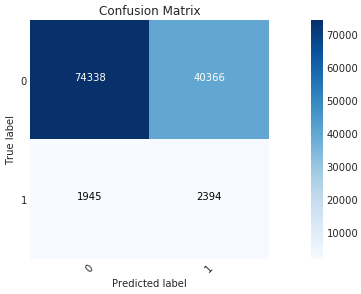

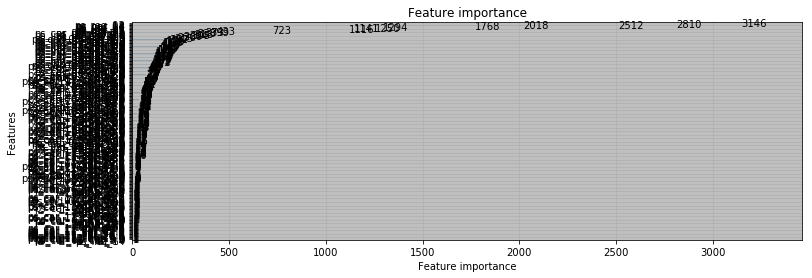

In [50]:
params['learning_rate']=0.01
lgbc=lgb.LGBMClassifier(**params)
get_lgb_params(params,cvparams,tran_table)
feat_imp=modelfit(lgbc,X_train,y_train,X_test,y_test,'auto',cvparams,useTrainCV=True,cv_folds=5,early_stopping_rounds=50)

In [52]:
params['n_estimators']=610

# 3 Final model

In [53]:
params

{'boosting_type': 'gbdt',
 'colsample_bytree': 0.65,
 'is_unbalance': True,
 'learning_rate': 0.01,
 'max_bin': 255,
 'max_depth': 16,
 'min_child_samples': 4,
 'min_child_weight': 2.9,
 'min_split_gain': 0,
 'n_estimators': 610,
 'n_jobs': 4,
 'num_leaves': 50,
 'objective': 'binary',
 'random_state': 9,
 'reg_alpha': 39.15,
 'reg_lambda': 2.5,
 'subsample': 0.98,
 'subsample_freq': 1}

In [54]:
lgbc_opt=lgb.LGBMClassifier(**params)

### cv

In [55]:
searchParam={'n_estimators':[610]}
turnParams(lgbc_opt,X,y,'auto',searchParam,params,scoring='roc_auc',cv=5);

Best params:
n_estimators : 610
Best score: 0.642507487303
     mean_test_score  mean_train_score  std_test_score  std_train_score
610         0.642507          0.696729        0.002792         0.000703


In [56]:
lgbc_opt.fit(X,y,feature_name=list(X.columns),categorical_feature='auto')

LGBMClassifier(boosting_type='gbdt', colsample_bytree=0.65, is_unbalance=True,
        learning_rate=0.01, max_bin=255, max_depth=16, min_child_samples=4,
        min_child_weight=2.9, min_split_gain=0, n_estimators=610, n_jobs=4,
        num_leaves=50, objective='binary', random_state=9, reg_alpha=39.15,
        reg_lambda=2.5, silent=True, subsample=0.98,
        subsample_for_bin=50000, subsample_freq=1)

In [57]:
joblib.dump(lgbc_opt,r'D:\study\Competition\kaggle-PSSDP-20171014\20171107_18LightGBM_dummy_RTE_del_calc.pkl')

['D:\\study\\Competition\\kaggle-PSSDP-20171014\\20171107_18LightGBM_dummy_RTE_del_calc.pkl']

In [58]:
pred_prob=lgbc_opt.predict_proba(X_predict)[:,1]

In [59]:
predict_result=pd.DataFrame({'id':test_df['id'].astype(int),'target':pd.Series(pred_prob,index=test_df['id'].index)})

In [60]:
predict_result.head()

,id,target
0,0,0.428301
1,1,0.386169
2,2,0.394907
3,3,0.269691
4,4,0.505694


In [61]:
predict_result.to_csv(r'D:\study\Competition\kaggle-PSSDP-20171014\20171107_18LightGBM_dummy_RTE_del_calc.csv',index=False)

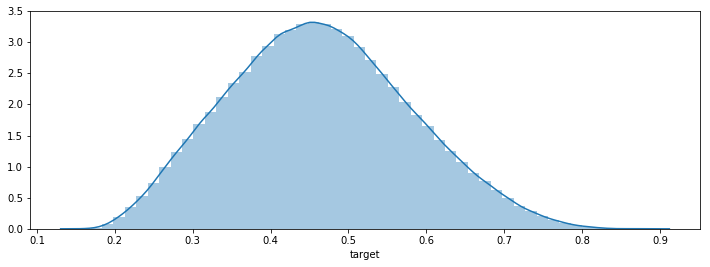

In [62]:
sns.distplot(predict_result['target'])

In [63]:
predict_result['target'].describe()

count    892816.000000
mean          0.463060
std           0.115733
min           0.154190
25%           0.379312
50%           0.459259
75%           0.541893
max           0.888450
Name: target, dtype: float64